<a href="https://colab.research.google.com/github/marcio-costa/stock_prediction/blob/master/HW_Week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from time import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
#Import library to allow this notebbok to access my google drive

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install yfinance --upgrade --no-cache-dir

  Created wheel for yfinance: filename=yfinance-0.1.45-cp36-none-any.whl size=14652 sha256=f45694239a04ce85db9a753221379354dbbd812a56c6a3859efed2a88df7d320
  Stored in directory: /tmp/pip-ephem-wheel-cache-egnl527y/wheels/0c/d1/df/aa9a7744a4ac353cc9a1f2c3aaea7c1f457fc49de4286f2d88
Successfully built yfinance


In [12]:
yf.pdr_override()
df_full = pdr.get_data_yahoo("GOOGL", start="2019-01-01").reset_index()
df_full.to_csv('GOOGL.csv',index=False)
print(df_full.head())
print(df_full.shape)

[*********************100%***********************]  1 of 1 downloaded
        Date         Open         High  ...        Close    Adj Close   Volume
0 2019-01-02  1027.199951  1060.790039  ...  1054.680054  1054.680054  1593400
1 2019-01-03  1050.670044  1066.260010  ...  1025.469971  1025.469971  2098000
2 2019-01-04  1042.560059  1080.000000  ...  1078.069946  1078.069946  2301100
3 2019-01-07  1080.969971  1082.699951  ...  1075.920044  1075.920044  2372300
4 2019-01-08  1086.000000  1093.349976  ...  1085.369995  1085.369995  1770700

[5 rows x 7 columns]
(168, 7)


In [13]:
df_full.describe()

,Open,High,Low,Close,Adj Close,Volume
count,168.000000,168.000000,168.000000,168.000000,168.000000,1.680000e+02
mean,1149.041487,1158.683155,1139.426372,1149.968748,1149.968748,1.612245e+06
std,54.011370,53.903682,54.794753,54.566040,54.566040,8.127839e+05
min,1027.199951,1050.000000,1022.369995,1025.469971,1025.469971,7.076000e+05
25%,1110.204956,1117.812500,1100.375000,1107.100037,1107.100037,1.172200e+06
50%,1146.445007,1153.724976,1138.195007,1148.285034,1148.285034,1.438250e+06
75%,1190.902496,1200.237457,1181.895020,1190.777527,1190.777527,1.766725e+06
max,1280.510010,1296.969971,1271.709961,1296.199951,1296.199951,6.658900e+06


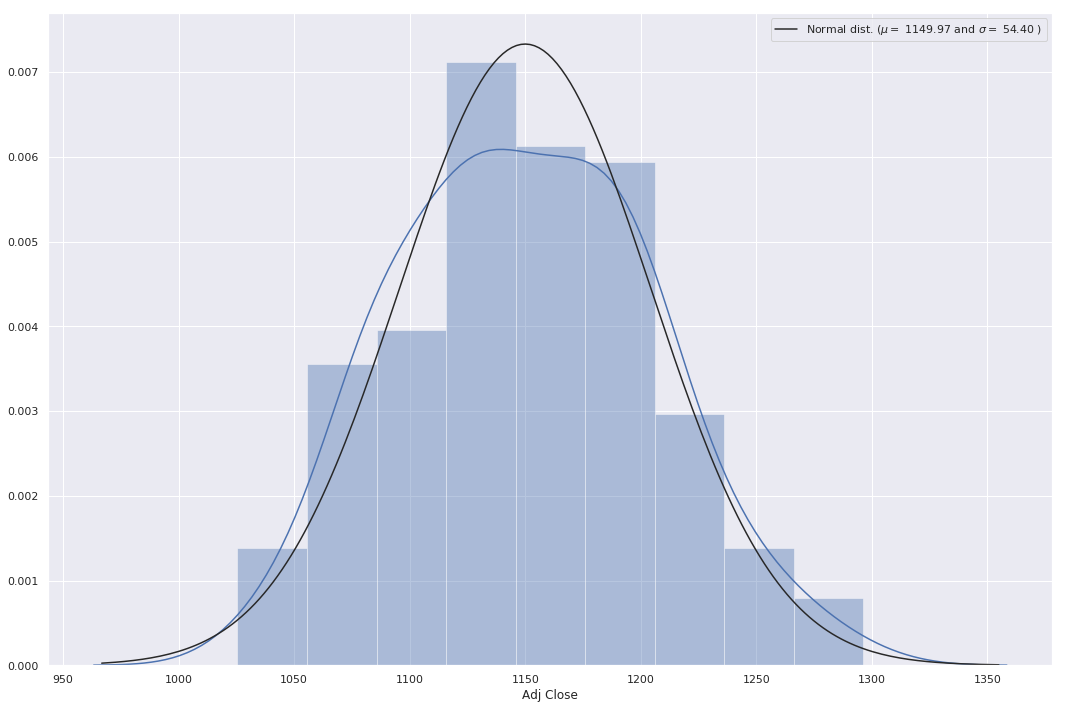

In [30]:
# Histogram on the target Adj Close
plt.subplots(figsize=(18,12))
sns.distplot(df_full['Adj Close'], fit=stats.norm)

# Add parameters
(mu, sigma) = stats.norm.fit(df_full['Adj Close'])

# Plotting
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')

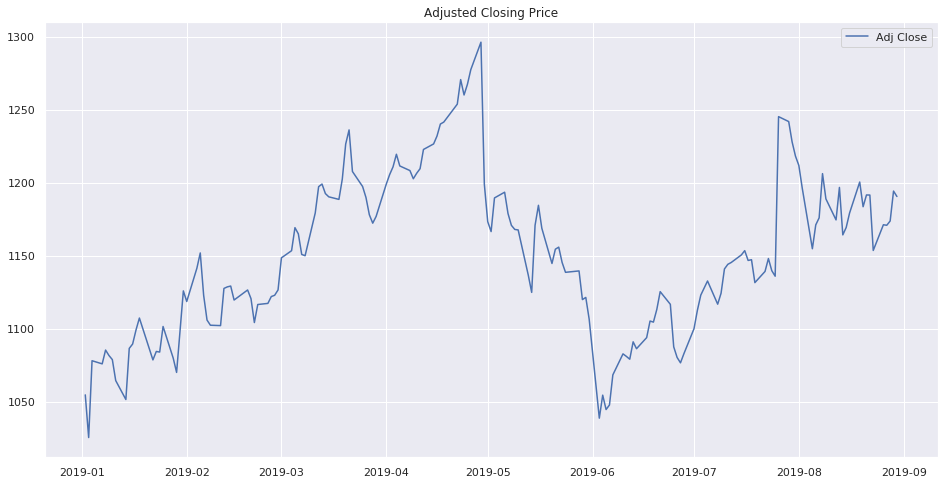

In [80]:
#Ploting
fig = plt.figure(figsize = (16,8))
plt.plot(df_full['Date'],df_full['Adj Close'])
plt.title('Adjusted Closing Price')
plt.legend()
plt.show()

In [34]:
# The variables 'Open', 'High', 'Low', 'Close', 'Volume' will be used to predict the target (Adj Close)
features = ['Open', 'High', 'Low', 'Close', 'Volume']
X = df_full[features]
print(X.head())
print(X.shape)

          Open         High          Low        Close   Volume
0  1027.199951  1060.790039  1025.280029  1054.680054  1593400
1  1050.670044  1066.260010  1022.369995  1025.469971  2098000
2  1042.560059  1080.000000  1036.859985  1078.069946  2301100
3  1080.969971  1082.699951  1062.640015  1075.920044  2372300
4  1086.000000  1093.349976  1068.349976  1085.369995  1770700
(168, 5)


In [33]:
# Model will predict 'Adj Close' value
y = df_full['Adj Close'].values
print(y[:5])
print(y.shape)

[1054.680054 1025.469971 1078.069946 1075.920044 1085.369995]
(168,)


In [37]:
# split data into training and validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 40)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(134, 5)
(134,)
(34, 5)
(34,)


In [0]:
#Define RMSE (Root Mean Square Error) to evaluate the models
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [0]:
#Define the pipeline 

def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Measure the time to create the model
    start = time() 
    learner = learner.fit(X_train, y_train)
    end = time() 
    
    # Calculating the time took to create the model
    results['train_time'] = end - start
        
    # Measure the time to predict
    start = time() # Get start time
    predictions_train = learner.predict(X_train)
    predictions_test = learner.predict(X_test)
    end = time() # Get end time
    
    # Calculating the time took to predict
    results['pred_time'] = end - start
            
    # RMSE of the train dataset
    results['rmse_train'] = rmse_cv_train(learner).mean()

    # RMSE of the test dataset
    results['rmse_test'] = rmse_cv_test(learner).mean()
	
    # Score and time spent
    print(f"The Model {learner.__class__.__name__} took {results['train_time']} to create the model and {results['pred_time']} to predict. The train score is {results['rmse_train']} and test score is {results['rmse_test']}")
    
    # Return do resultados
    return results

In [0]:
# Starting the models
clf_1 = linear_model.Lasso(alpha=0.1, random_state = 40)
clf_2 = SVR(gamma='scale', C=1.0, epsilon=0.2)
clf_3 = DecisionTreeRegressor(random_state=40)
clf_4 = RandomForestRegressor(max_depth=2, n_estimators=100, random_state=40)

In [70]:
# Running the models 
results = {}
for clf in [clf_1, clf_2, clf_3, clf_4]:
    clf_name = clf.__class__.__name__
    results[clf_name] = train_predict(clf, X_train, y_train, X_test, y_test)

The Model Lasso took 0.0033440589904785156 to create the model and 0.007215261459350586 to predict. The train score is 0.023822727330748462 and test score is 0.02471917214878141
The Model SVR took 0.002252817153930664 to create the model and 0.0020105838775634766 to predict. The train score is 54.14459475956551 and test score is 52.78529385645466
The Model DecisionTreeRegressor took 0.0012753009796142578 to create the model and 0.0013184547424316406 to predict. The train score is 5.808450200659841 and test score is 8.54136865201248
The Model RandomForestRegressor took 0.05315971374511719 to create the model and 0.009730815887451172 to predict. The train score is 12.552279360902064 and test score is 11.951274311729724


In [72]:
df_performance = pd.DataFrame(results)
df_performance


,Lasso,SVR,DecisionTreeRegressor,RandomForestRegressor
pred_time,0.007215,0.002011,0.001318,0.009731
rmse_test,0.024719,52.785294,8.541369,11.951274
rmse_train,0.023823,54.144595,5.808450,12.552279
train_time,0.003344,0.002253,0.001275,0.053160


In [76]:
#Best model based on RMSE - Test dataset
smallest_rmse = df_performance.loc['rmse_test'].min()
best_model = df_performance.loc['rmse_test'] == smallest_rmse
best_model

Lasso                     True
SVR                      False
DecisionTreeRegressor    False
RandomForestRegressor    False
Name: rmse_test, dtype: bool